# **MNIST Digits prediction with feed forward Neural Networks and CNNs**

import libraries and data

In [1]:
from keras.datasets import mnist
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot
from sklearn.metrics import precision_recall_fscore_support
import numpy as np



In [15]:
from torchvision import  transforms, datasets
from torch.utils.data import DataLoader

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, confusion_matrix
import seaborn as sns


Let's visualize what the data looks like


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


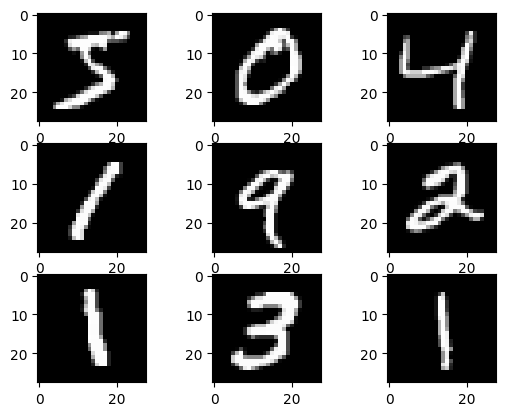

In [2]:
(trainX, trainy), (testX, testy) = mnist.load_data()

print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))

# show the figure
pyplot.show()

Let's ensure that the data is evenly distributed per class (if not, we would have to make corrections). We should expect that each class represents roughly 10% of the entire dataset.


In [3]:
for i in range(10):
  count_train = np.where(trainy == i)[0]
  count_test = np.where(testy == i)[0]

  print("Label %d - train: %.4f - test: %.4f" %(i, count_train.shape[0] / float(trainy.shape[0]), count_test.shape[0] / float(testy.shape[0]) ))

Label 0 - train: 0.0987 - test: 0.0980
Label 1 - train: 0.1124 - test: 0.1135
Label 2 - train: 0.0993 - test: 0.1032
Label 3 - train: 0.1022 - test: 0.1010
Label 4 - train: 0.0974 - test: 0.0982
Label 5 - train: 0.0903 - test: 0.0892
Label 6 - train: 0.0986 - test: 0.0958
Label 7 - train: 0.1044 - test: 0.1028
Label 8 - train: 0.0975 - test: 0.0974
Label 9 - train: 0.0992 - test: 0.1009


Ok, it looks good....we can work with these classes as is. Now let's start doing some prediction. We should split the training data into train and dev sets.


Now let's try building a 2-layer feed forward network to predict digits. Remember, each data point is a 28x28 image, so you will need to flatten it into a vector for a feed forward DNN.

In [5]:
# Flatten the 28x28 images into 784-dimensional vectors
trainX = trainX.reshape(trainX.shape[0], 784)
testX = testX.reshape(testX.shape[0], 784)

# Normalize the data
trainX = trainX / 255.0
testX = testX / 255.0


In [7]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [16]:
# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17459777.58it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 497965.95it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4399189.74it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4148634.31it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
#Define DNN class here

# Define the model
class TwoLayerNet(nn.Module):
    def __init__(self):
        super(TwoLayerNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = TwoLayerNet().to(device)

In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())


In [ ]:
#Train DNN and predict on test

In [22]:
# Training loop
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')



In [23]:
# Testing loop
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')


In [24]:
# Function to make predictions on the test set
def predict(model, device, test_loader):
    model.eval()
    predictions = []
    true_labels = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prob = nn.functional.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
            predictions.extend(pred.view(-1).tolist())
            true_labels.extend(target.view(-1).tolist())
            probabilities.extend(prob.cpu().numpy())
    return predictions, true_labels, np.array(probabilities)



In [25]:
# Function to visualize predictions
def visualize_predictions(images, true_labels, predicted_labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].set_title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


In [26]:
# Train the model
for epoch in range(1, 6):  # Train for 5 epochs
    train(model, device, train_loader, optimizer, criterion, epoch)
    test(model, device, test_loader, criterion)

print('Training complete')


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.032996
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.058972
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.020075
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.064281
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.011500
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.002052
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.000996
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.003333
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.004775
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.121821
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.009845
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.003850
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.003367
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.051053
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.019996
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.012400
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.089499
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.012591
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.000203

Test set: Average loss: 0.0029, Accuracy: 9740/10000 (97.4

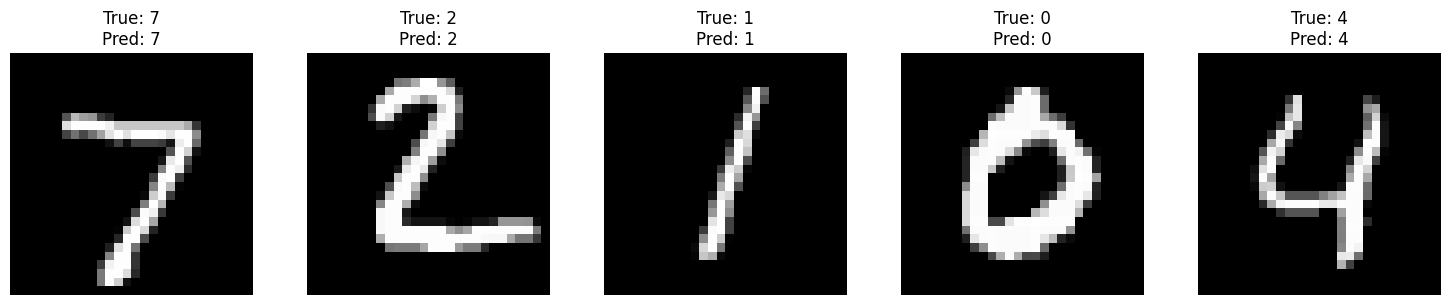

Overall accuracy on test set: 0.9774


In [20]:

# Make predictions on the test set
predicted_labels, true_labels = predict(model, device, test_loader)

# Visualize some predictions
test_images = [test_dataset[i][0] for i in range(5)]  # Get the first 5 test images
visualize_predictions(test_images, true_labels[:5], predicted_labels[:5])

# Print overall accuracy
accuracy = sum([1 for p, t in zip(predicted_labels, true_labels) if p == t]) / len(true_labels)
print(f"Overall accuracy on test set: {accuracy:.4f}")

Report:
- precision
- recall
- ROC curve
- confusion matrix

Precision: 0.9778
Recall: 0.9777


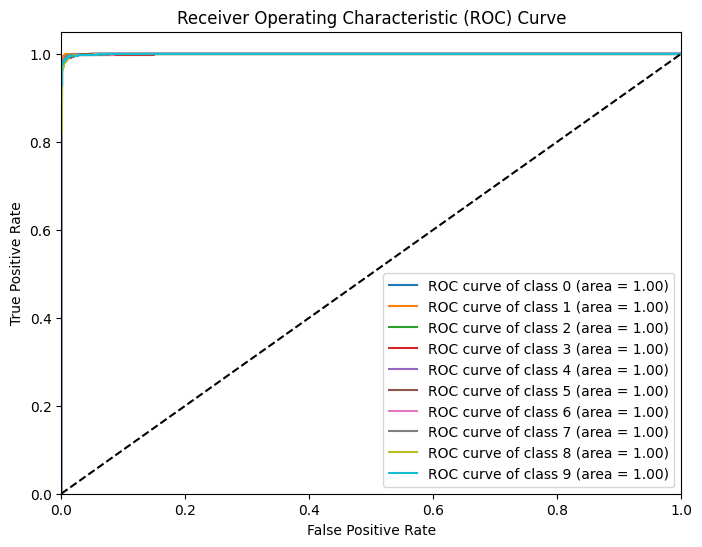

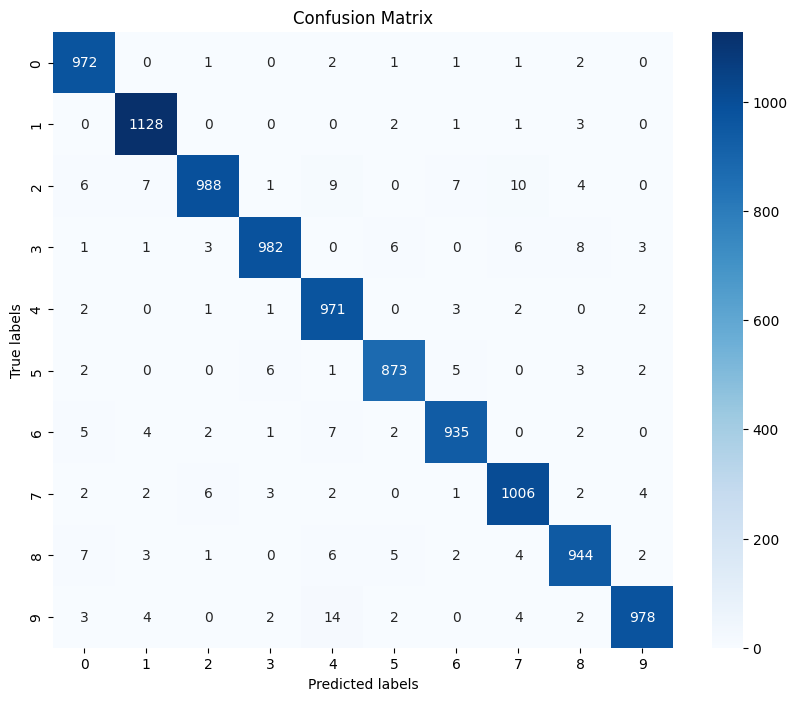

In [27]:

# Make predictions on the test set
predicted_labels, true_labels, probabilities = predict(model, device, test_loader)

# Calculate precision and recall
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):  # 10 classes in MNIST
    fpr[i], tpr[i], _ = roc_curve((np.array(true_labels) == i).astype(int), probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate and plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Now let's build a CNN network for image recognition.

In [28]:
# Define CNN

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)


In [29]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())


In [30]:
# Training function
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Testing function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    return accuracy

# Function to make predictions and get probabilities
def predict(model, device, test_loader):
    model.eval()
    predictions = []
    true_labels = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prob = nn.functional.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
            predictions.extend(pred.cpu().numpy())
            true_labels.extend(target.cpu().numpy())
            probabilities.extend(prob.cpu().numpy())
    return np.array(predictions).flatten(), np.array(true_labels), np.array(probabilities)

In [31]:
# Train CNN and predict on test
# Train the model
epochs = 10
accuracies = []

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch)
    accuracy = test(model, device, test_loader)
    accuracies.append(accuracy)

print('Training complete')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303670
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.187458
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.079706
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.249502
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.035966
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.106743
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.181105
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.023100
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.041235
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.085480
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.027113
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.124378
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.072152
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.133934
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.159001
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.184730
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.028092
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.023554
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.034194

Test set: Average loss: 0.0013, Accuracy: 9858/10000 (98.5

Report:
- precision
- recall
- ROC curve
- confusion matrix

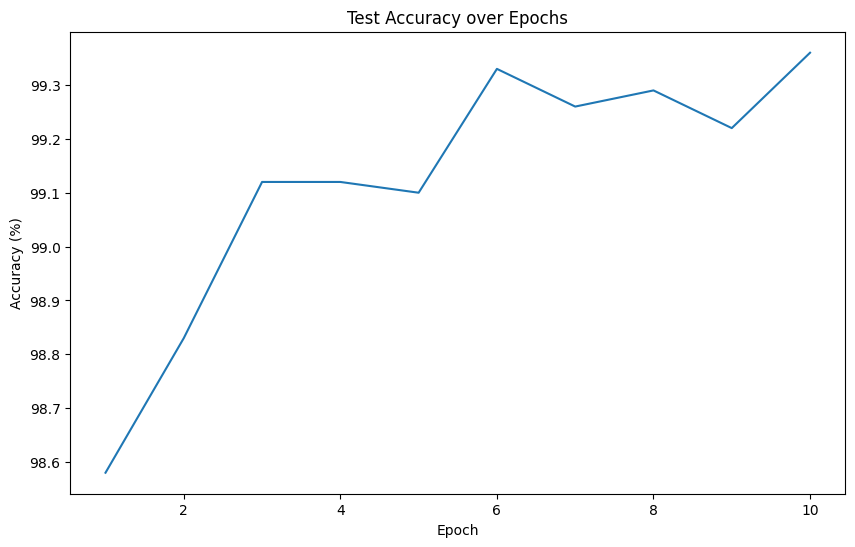

Precision: 0.9936
Recall: 0.9936


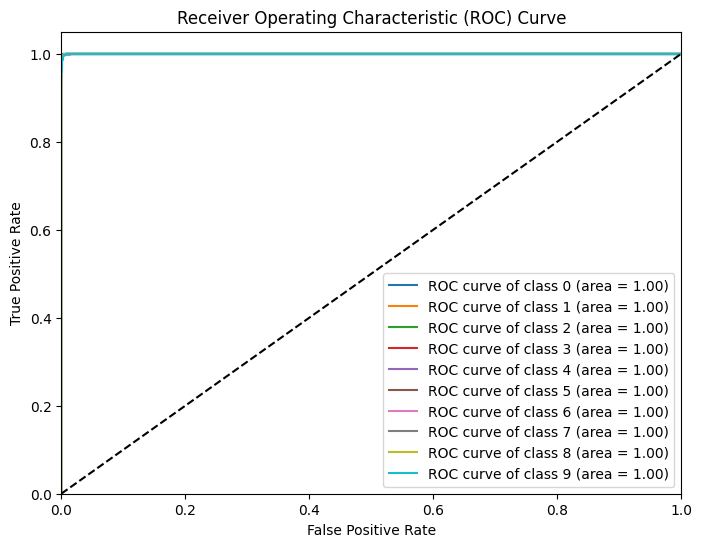

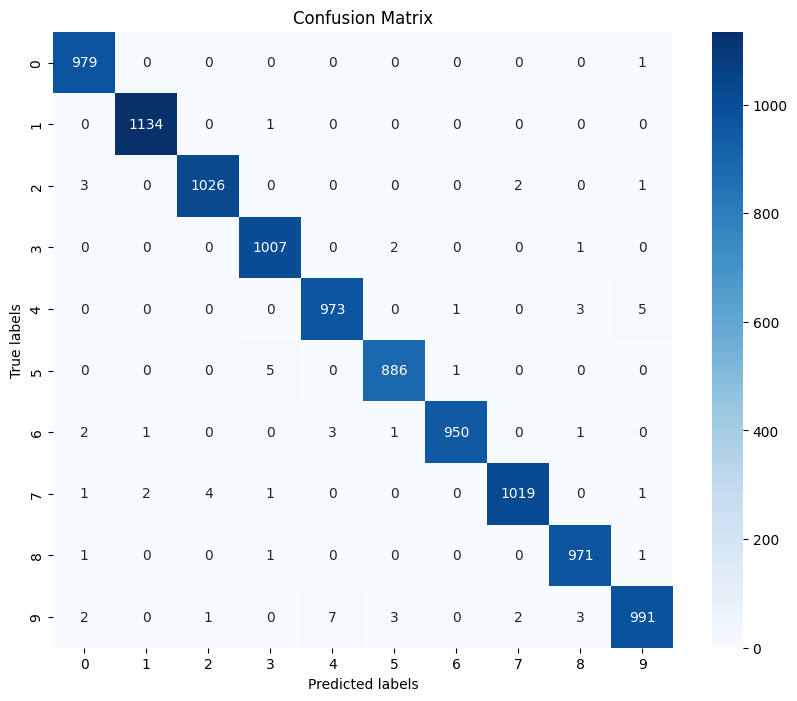

In [32]:
#Enter code here

# Plot accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), accuracies)
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

# Make predictions on the test set
predicted_labels, true_labels, probabilities = predict(model, device, test_loader)

# Calculate precision and recall
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):  # 10 classes in MNIST
    fpr[i], tpr[i], _ = roc_curve((true_labels == i).astype(int), probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate and plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

At this point, you should have seen an improvement in performance when using CNN for images over DNN. Look into the performance metrics (specially the confusion matrix), and try to identify where CNNs made a difference in performance.

Are there specific number pairs that were difficult for DNN but improved on CNN?

Finally, pick a pair of classes that have high confusion an plot examples that are confusing between them. Can you see why the confusion happens? (This type of post-hoc investigation is typical in the industry to understand why/when something might fail, and work towards fixing those edge cases).



In [35]:

# Function to train and evaluate a model
def train_and_evaluate(model, device, train_loader, test_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in range(1, epochs + 1):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            predictions.extend(pred.cpu().numpy())
            true_labels.extend(target.cpu().numpy())

    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')
    return np.array(predictions).flatten(), np.array(true_labels)

Test set: Accuracy: 9760/10000 (97.60%)
Test set: Accuracy: 9913/10000 (99.13%)


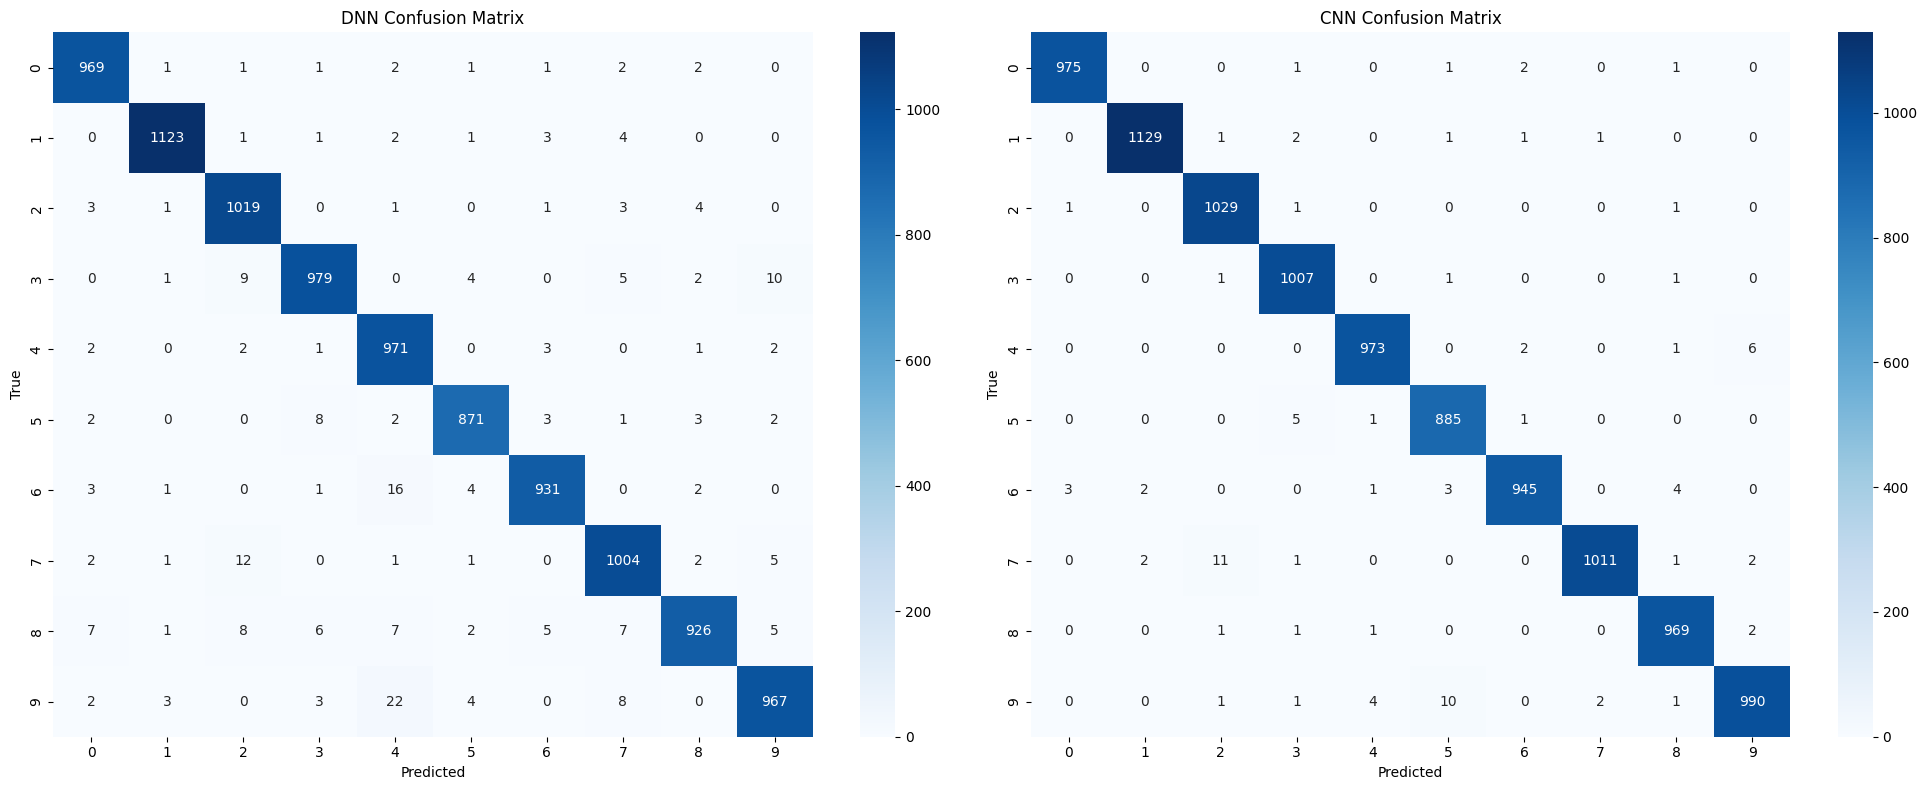

The most confused pair for CNN is (7, 2)


IndexError: index 0 is out of bounds for axis 0 with size 0

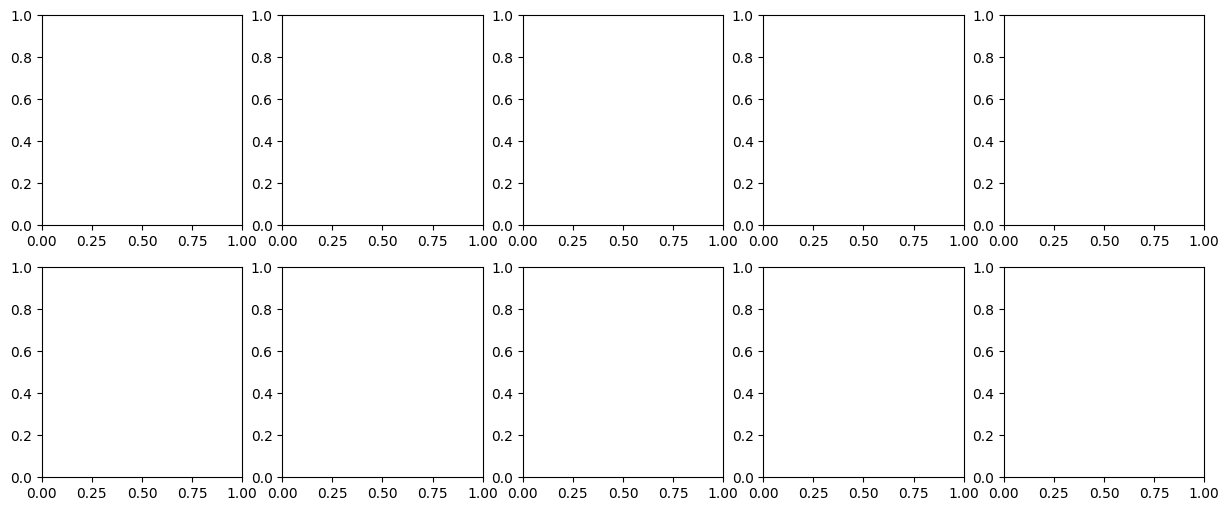

In [36]:
#Enter code here

# Train and evaluate DNN and CNN
dnn_model = TwoLayerNet().to(device)
cnn_model = CNN().to(device)

dnn_pred, dnn_true = train_and_evaluate(dnn_model, device, train_loader, test_loader)
cnn_pred, cnn_true = train_and_evaluate(cnn_model, device, train_loader, test_loader)

# Generate confusion matrices
dnn_cm = confusion_matrix(dnn_true, dnn_pred)
cnn_cm = confusion_matrix(cnn_true, cnn_pred)

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(dnn_cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('DNN Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('CNN Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')
plt.tight_layout()
plt.show()

# Find the most confused pair for CNN
cnn_cm_norm = cnn_cm.astype('float') / cnn_cm.sum(axis=1)[:, np.newaxis]
np.fill_diagonal(cnn_cm_norm, 0)
most_confused = np.unravel_index(np.argmax(cnn_cm_norm), cnn_cm_norm.shape)

print(f"The most confused pair for CNN is {most_confused}")

# Function to plot examples
def plot_examples(class1, class2, num_examples=5):
    fig, axes = plt.subplots(2, num_examples, figsize=(15, 6))
    for i in range(num_examples):
        # Find misclassified examples
        idx1 = np.where((cnn_true == class1) & (cnn_pred == class2))[0][i]
        idx2 = np.where((cnn_true == class2) & (cnn_pred == class1))[0][i]

        # Plot the examples
        axes[0, i].imshow(test_dataset[idx1][0].squeeze(), cmap='gray')
        axes[0, i].set_title(f"True: {class1}, Pred: {class2}")
        axes[0, i].axis('off')

        axes[1, i].imshow(test_dataset[idx2][0].squeeze(), cmap='gray')
        axes[1, i].set_title(f"True: {class2}, Pred: {class1}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot examples of the most confused pair
plot_examples(most_confused[0], most_confused[1])